# Telco Customer Churn: Exploratory Data Analysis

This notebook performs a comprehensive exploratory data analysis (EDA) on the Telco Customer Churn dataset. The goal is to understand the data, identify patterns, and extract insights that can inform feature engineering and model building.

## 1. Setup and Data Loading

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import os
import yaml

# Add src directory to path to import custom modules
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))

from src.data_loader import TelcoDataLoader

# Load config
with open('../config/config.yaml', 'r') as f:
    config = yaml.safe_load(f)

TARGET_COLUMN = config['target']
NUMERICAL_FEATURES = config['features']['numerical']
CATEGORICAL_FEATURES = config['features']['categorical']

# Set plot style
sns.set(style='whitegrid')

# Load data
loader = TelcoDataLoader()
df = loader.load_raw_data()

# Initial data preparation
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
df.dropna(subset=['TotalCharges'], inplace=True)

Successfully loaded data from C:\Users\IPK\Telco churn project 1\telco-churn-production\data\raw\telco_churn.csv


## 2. Data Quality Assessment

In [2]:
print('--- DataFrame Info ---')
df.info()

print('\n--- Missing Values ---')
print(df.isnull().sum())

print('\n--- Duplicate Rows ---')
print(f'Number of duplicate rows: {df.duplicated().sum()}')

print('\n--- Summary Statistics ---')
print(df.describe())

--- DataFrame Info ---
<class 'pandas.core.frame.DataFrame'>
Index: 7032 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7032 non-null   object 
 1   gender            7032 non-null   object 
 2   SeniorCitizen     7032 non-null   int64  
 3   Partner           7032 non-null   object 
 4   Dependents        7032 non-null   object 
 5   tenure            7032 non-null   int64  
 6   PhoneService      7032 non-null   object 
 7   MultipleLines     7032 non-null   object 
 8   InternetService   7032 non-null   object 
 9   OnlineSecurity    7032 non-null   object 
 10  OnlineBackup      7032 non-null   object 
 11  DeviceProtection  7032 non-null   object 
 12  TechSupport       7032 non-null   object 
 13  StreamingTV       7032 non-null   object 
 14  StreamingMovies   7032 non-null   object 
 15  Contract          7032 non-null   object 
 16  PaperlessBilling  7032 n

## 3. Univariate Analysis

### Target Variable

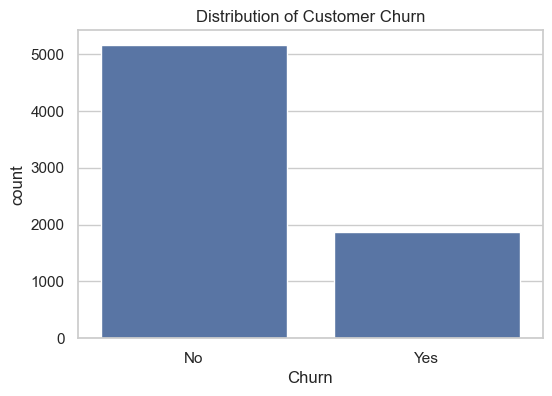

Churn
No     0.734215
Yes    0.265785
Name: proportion, dtype: float64


In [3]:
plt.figure(figsize=(6, 4))
sns.countplot(x=TARGET_COLUMN, data=df)
plt.title('Distribution of Customer Churn')
plt.show()
print(df[TARGET_COLUMN].value_counts(normalize=True))

### Numerical Features

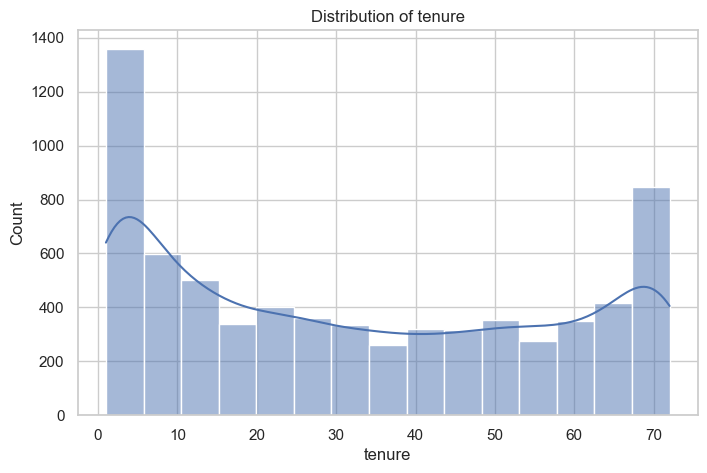

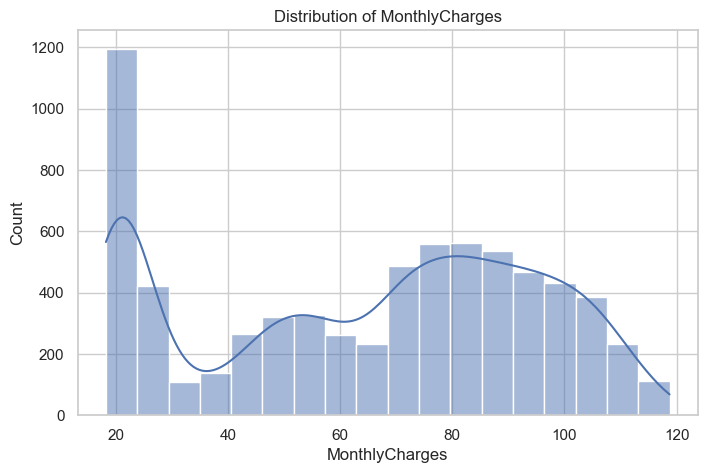

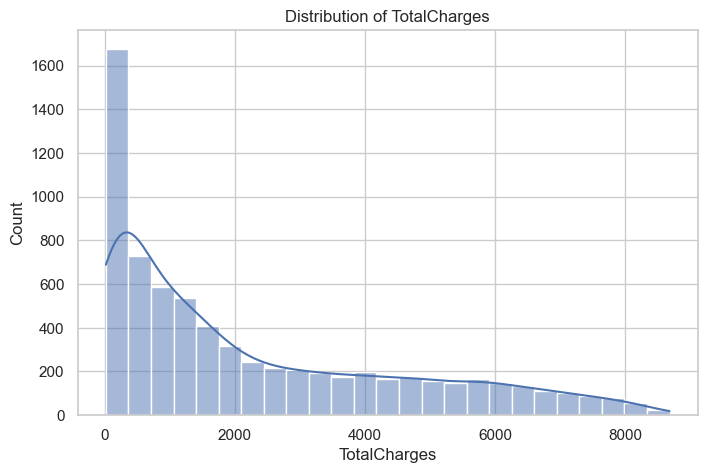

In [4]:
for col in NUMERICAL_FEATURES:
    plt.figure(figsize=(8, 5))
    sns.histplot(df[col], kde=True)
    plt.title(f'Distribution of {col}')
    plt.show()

### Categorical Features

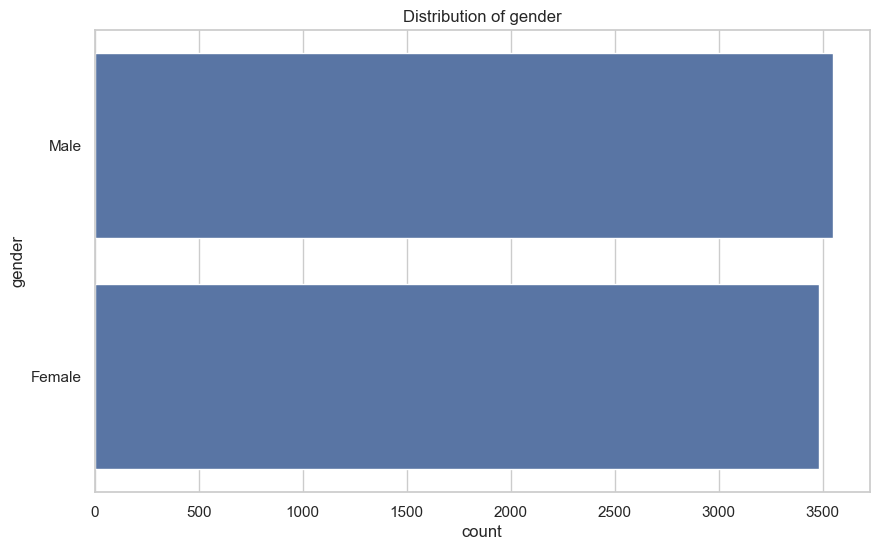

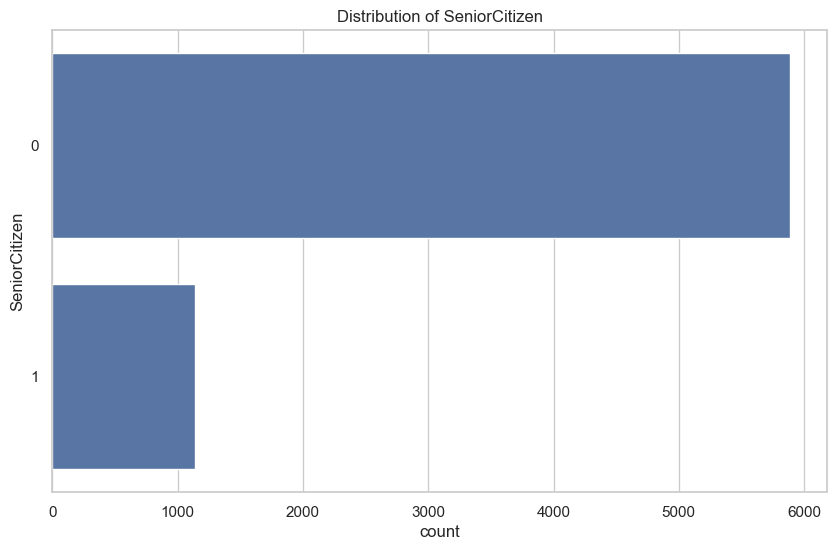

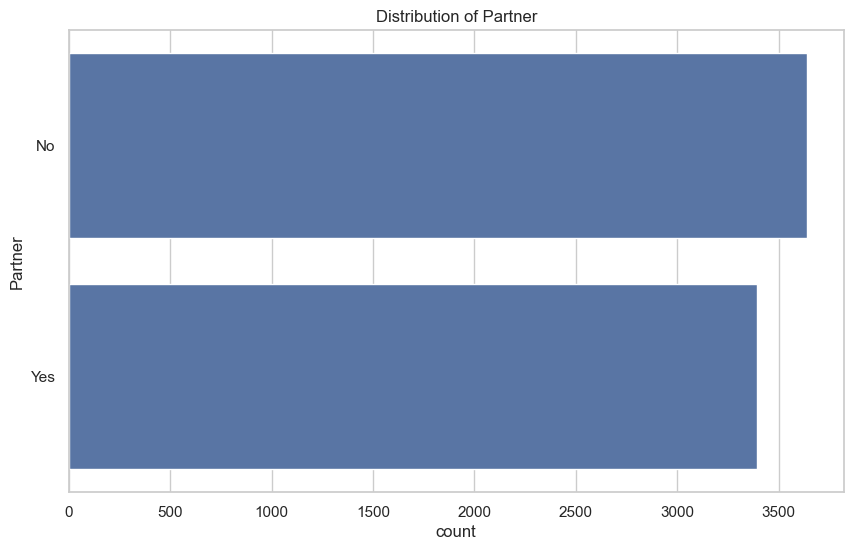

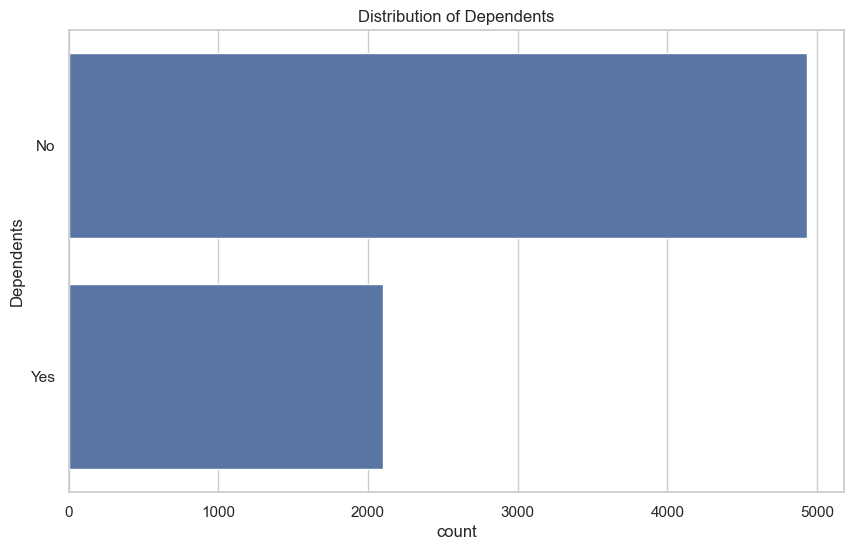

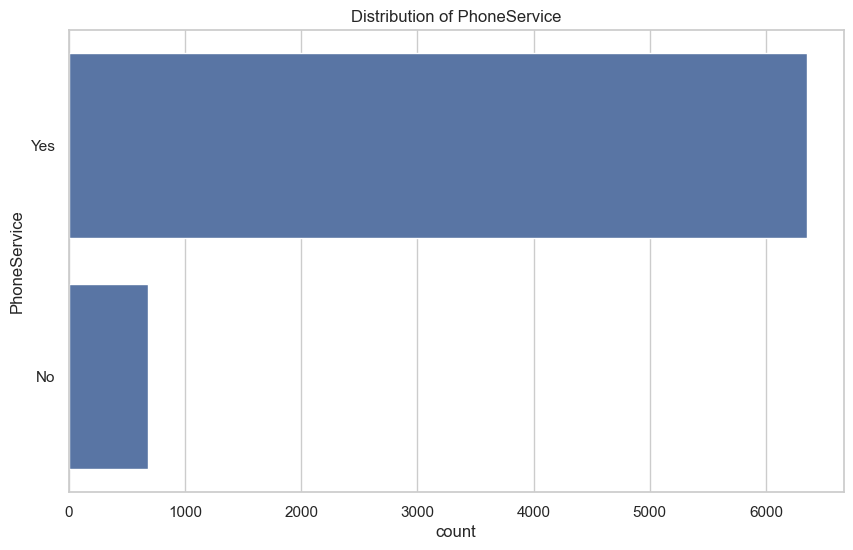

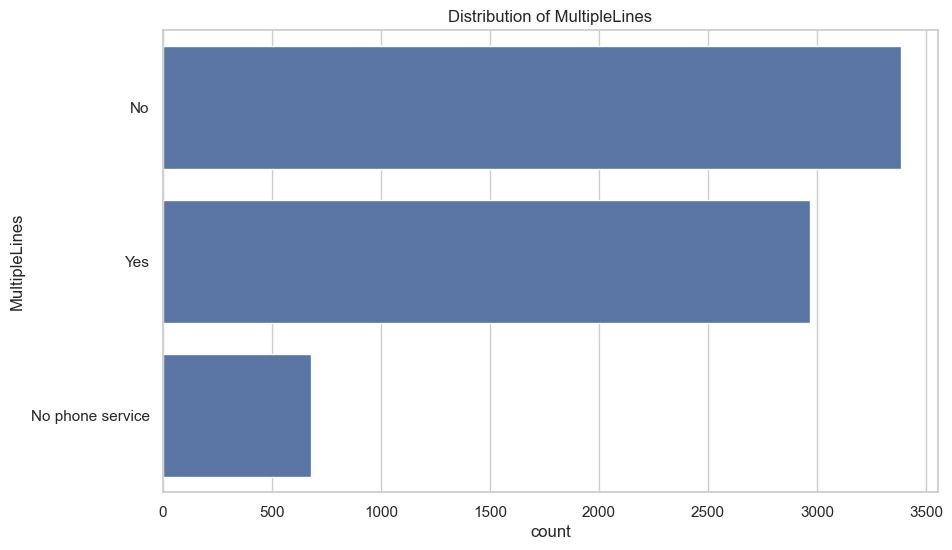

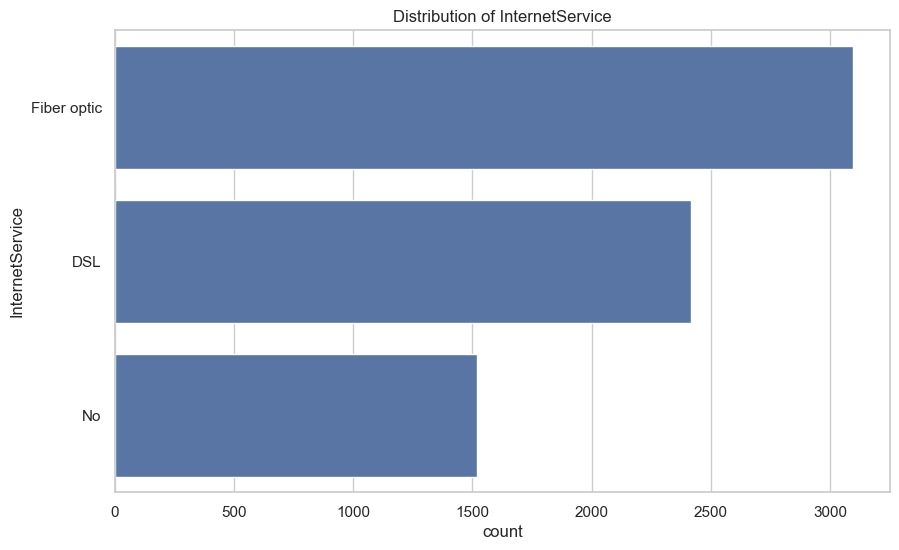

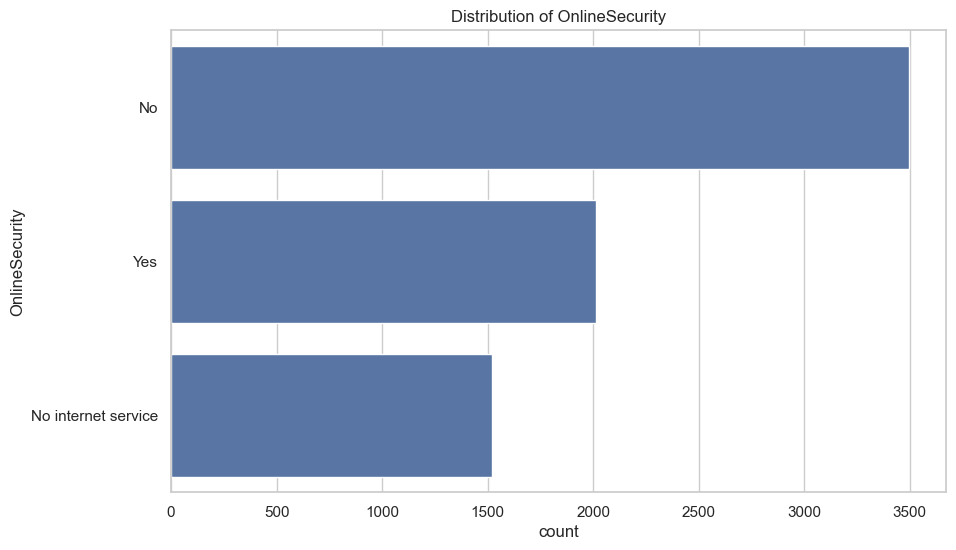

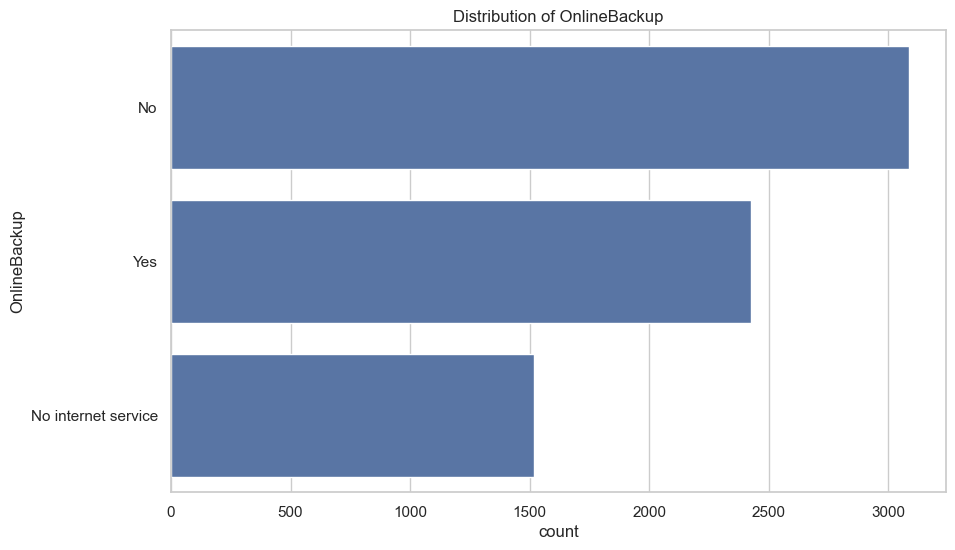

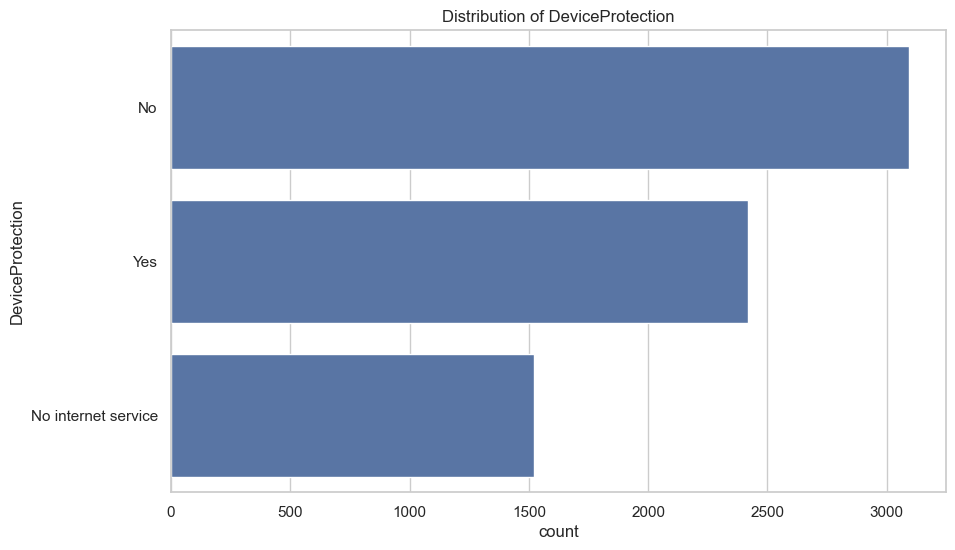

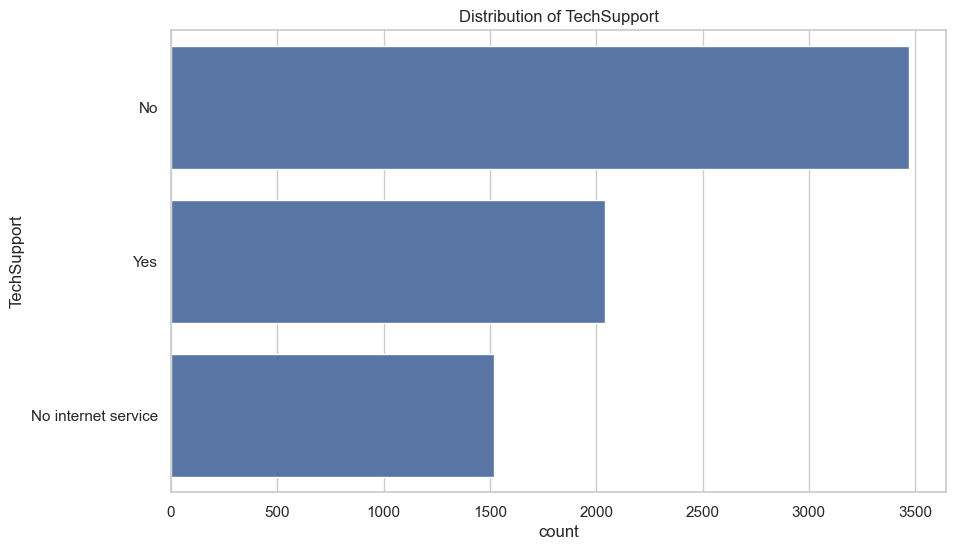

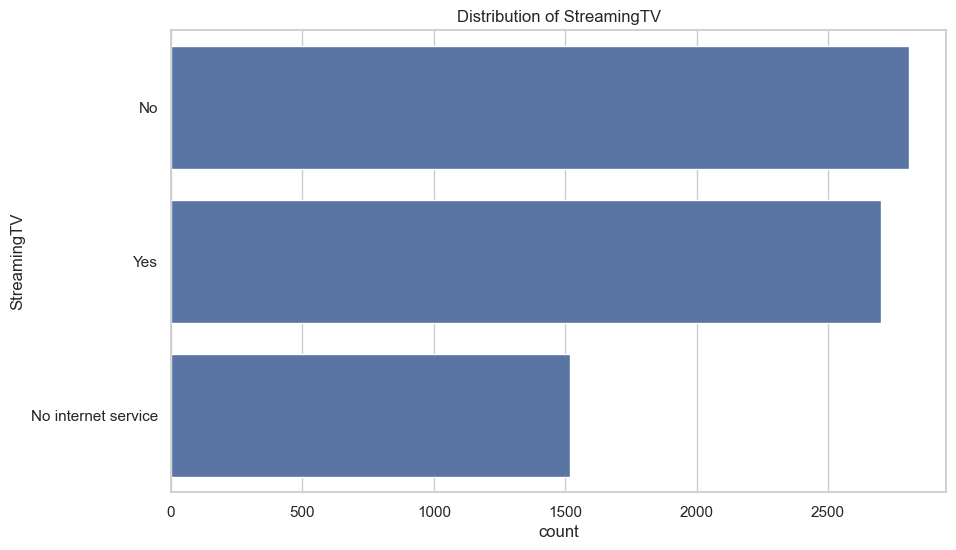

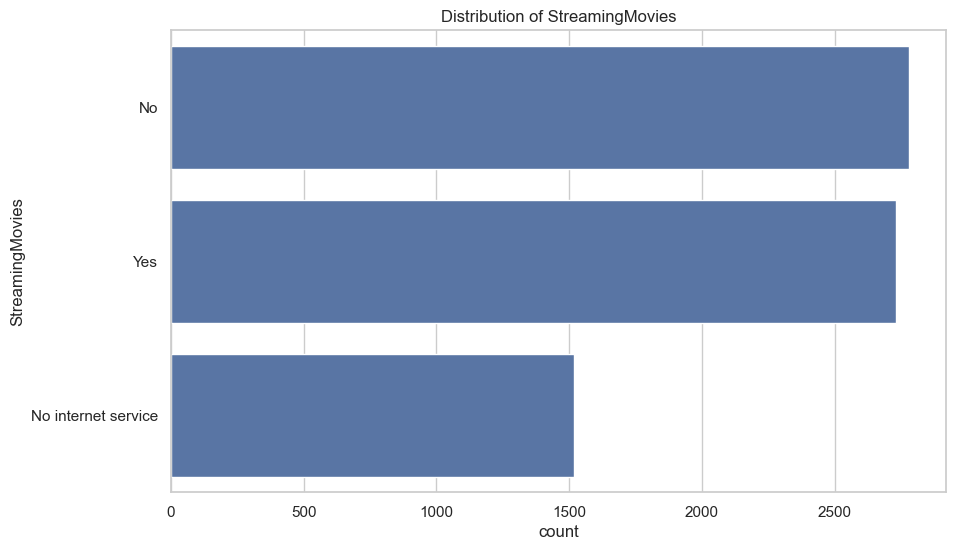

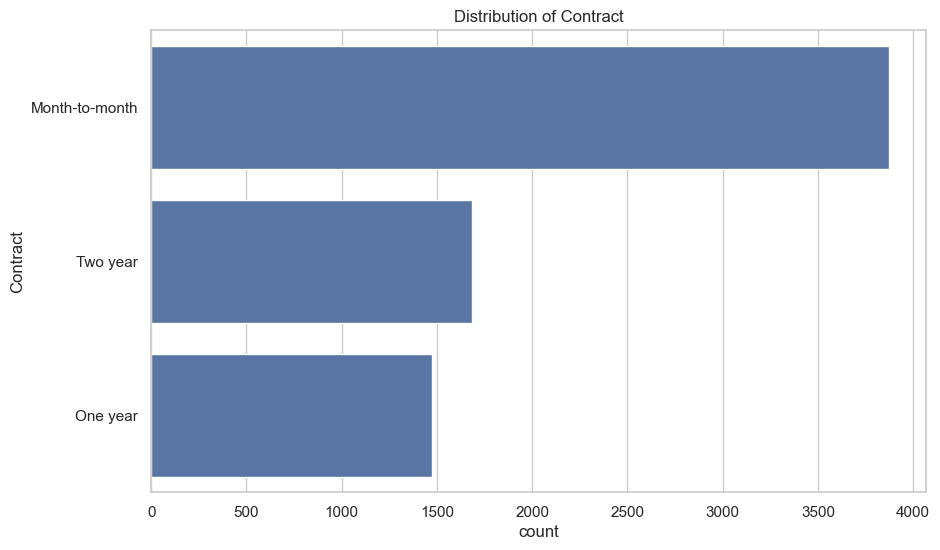

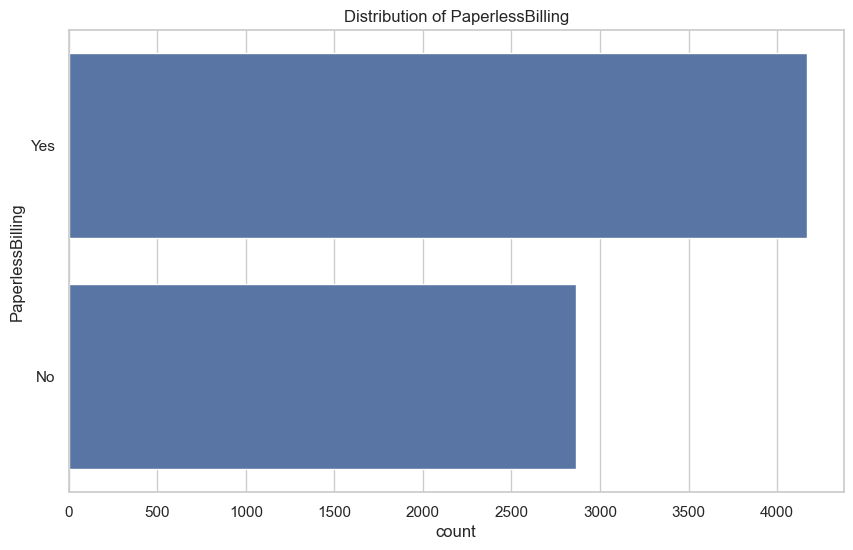

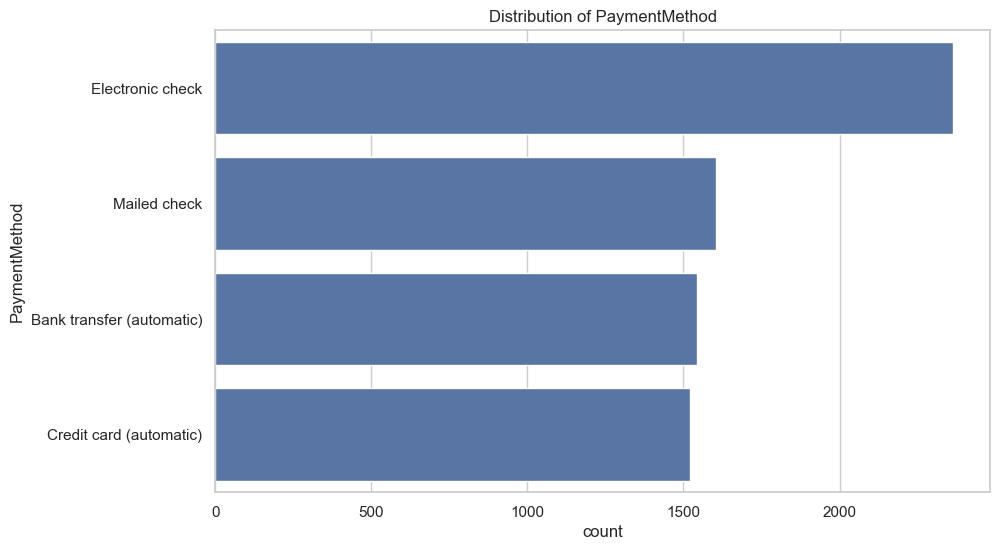

In [5]:
for col in CATEGORICAL_FEATURES:
    plt.figure(figsize=(10, 6))
    sns.countplot(y=col, data=df, order=df[col].value_counts().index)
    plt.title(f'Distribution of {col}')
    plt.show()

## 4. Bivariate Analysis

### Numerical Features vs. Churn

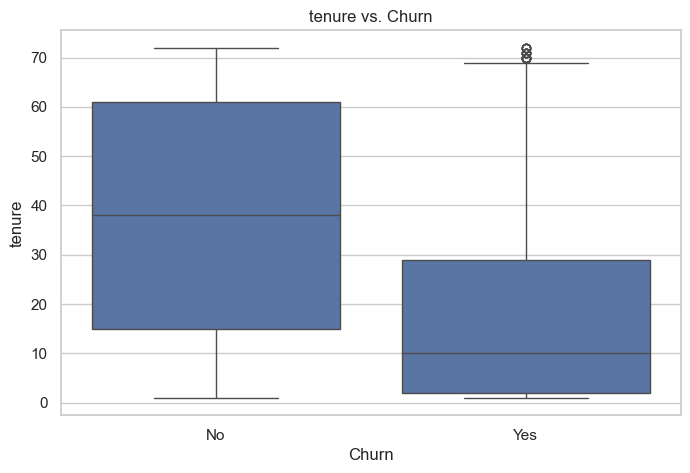

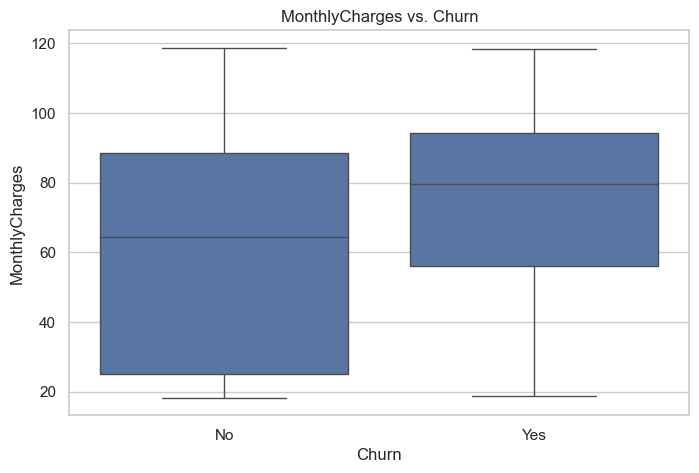

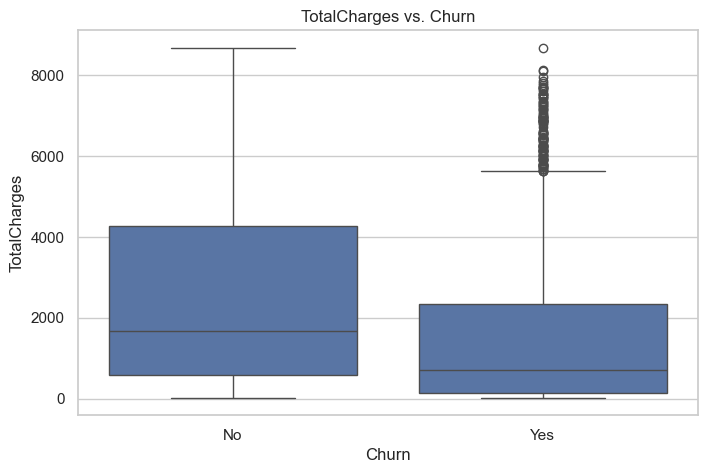

In [6]:
for col in NUMERICAL_FEATURES:
    plt.figure(figsize=(8, 5))
    sns.boxplot(x=TARGET_COLUMN, y=col, data=df)
    plt.title(f'{col} vs. Churn')
    plt.show()

### Categorical Features vs. Churn

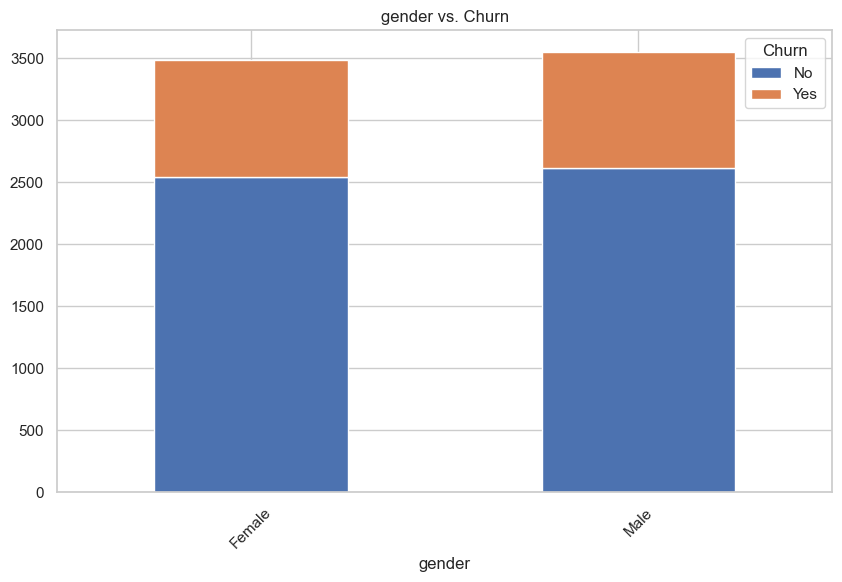

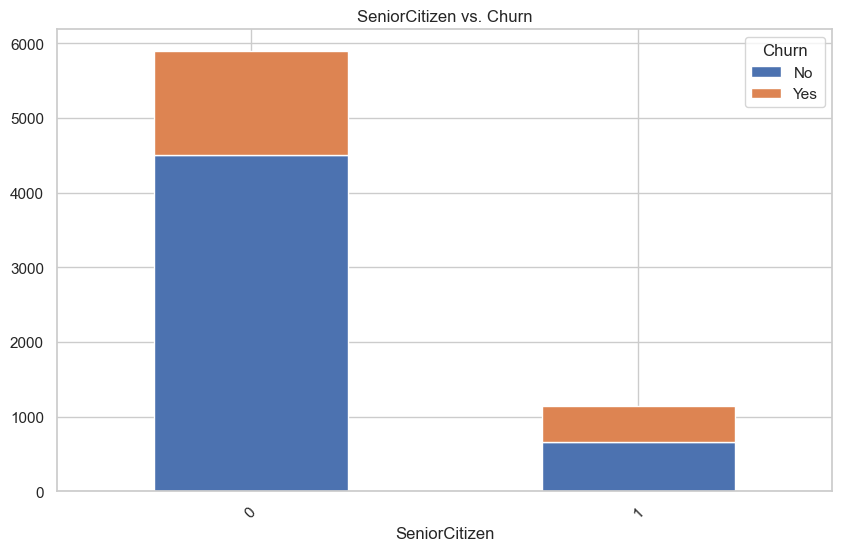

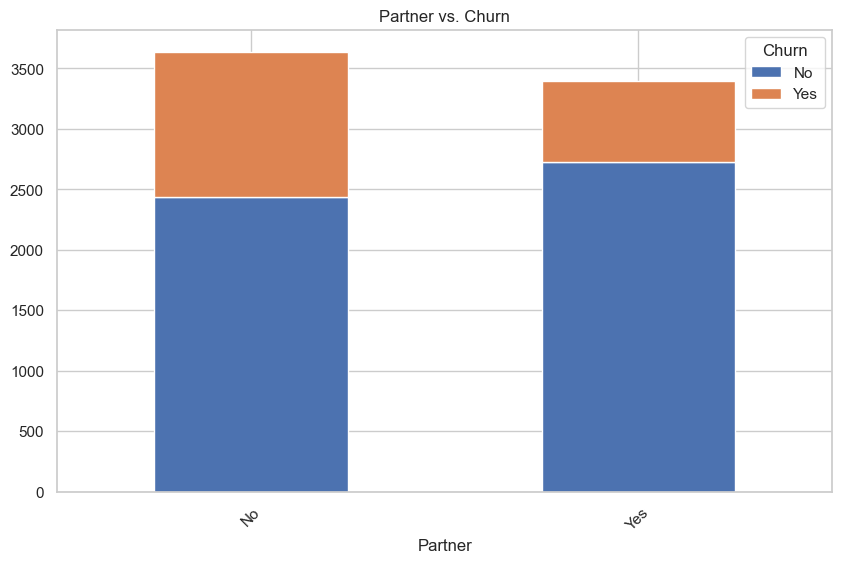

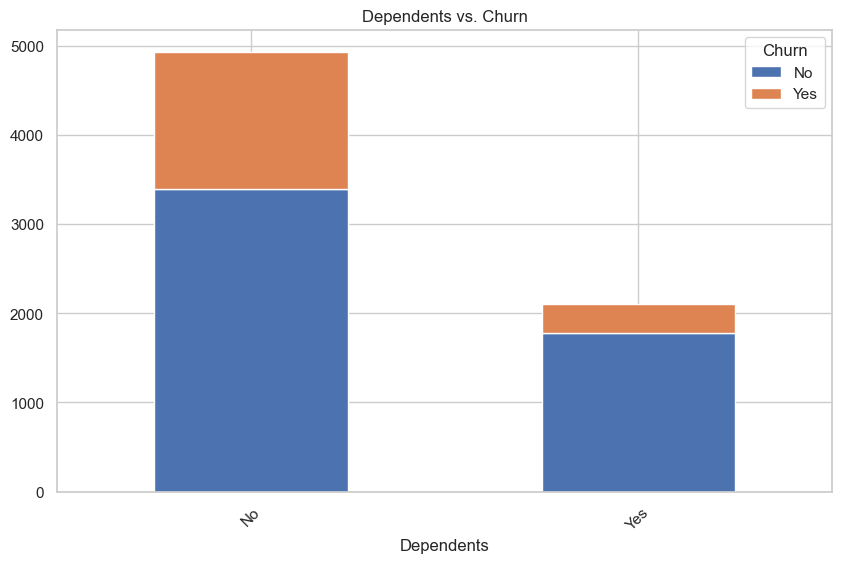

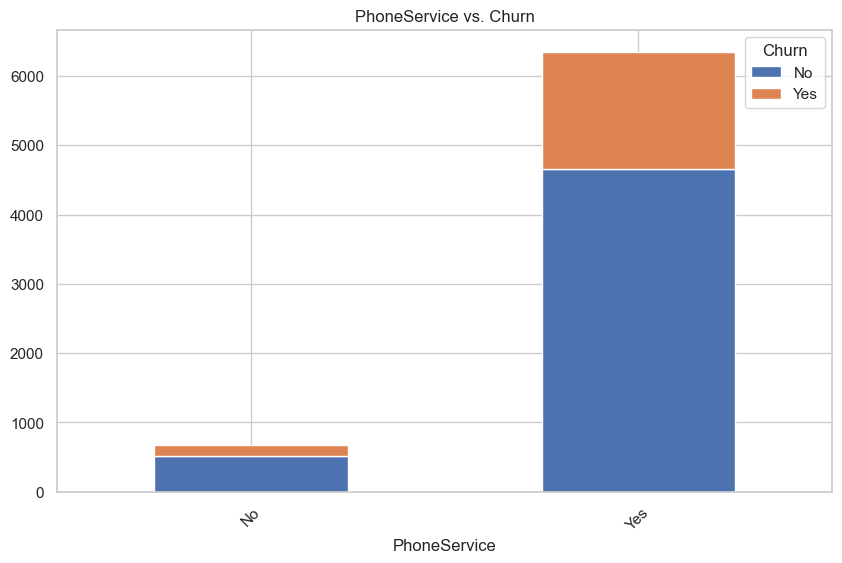

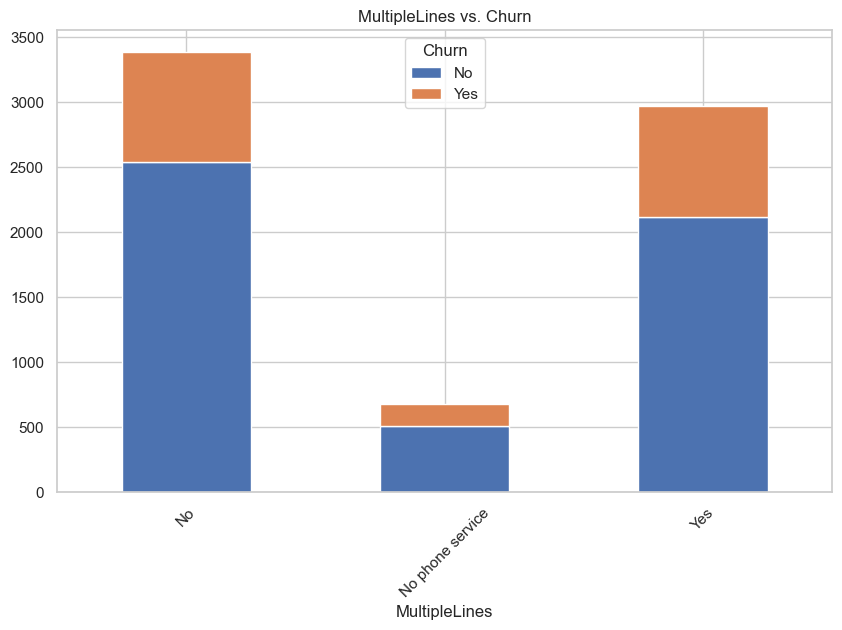

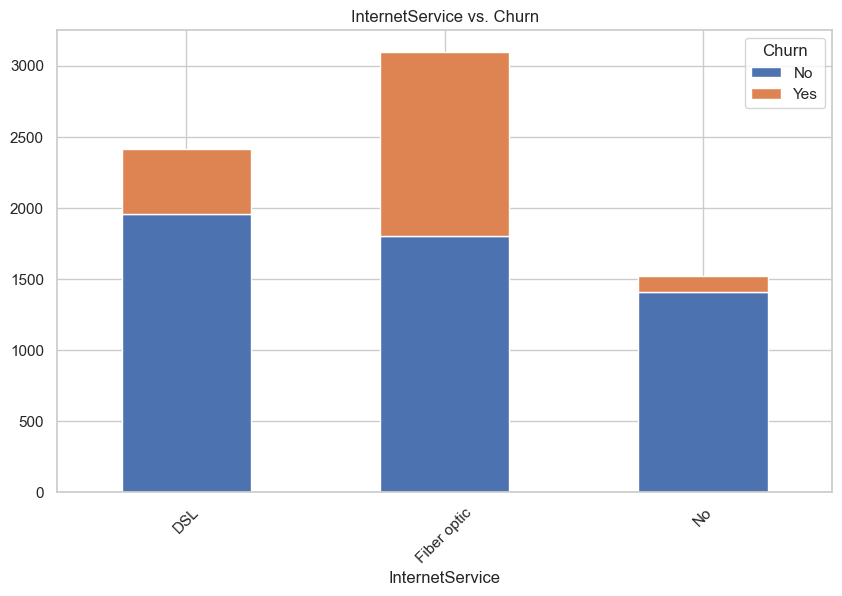

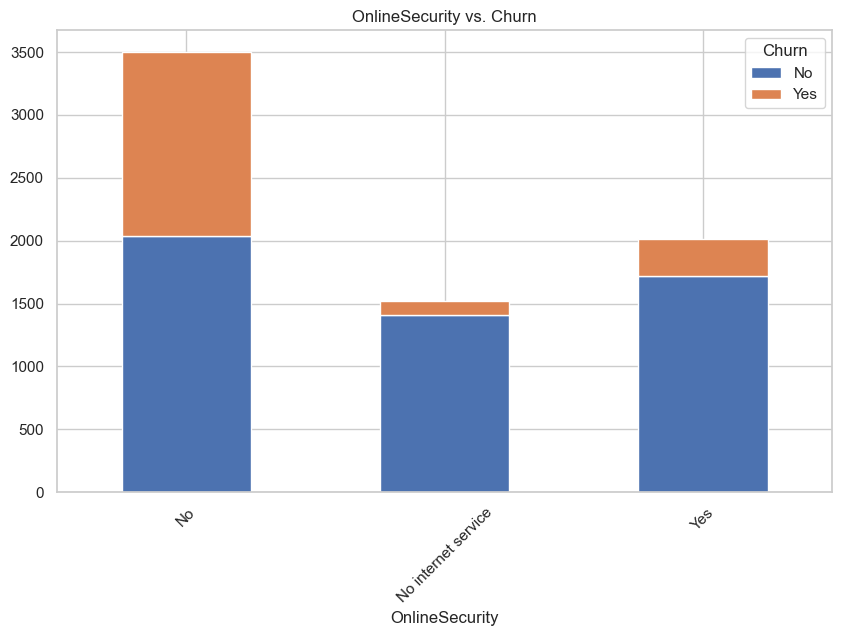

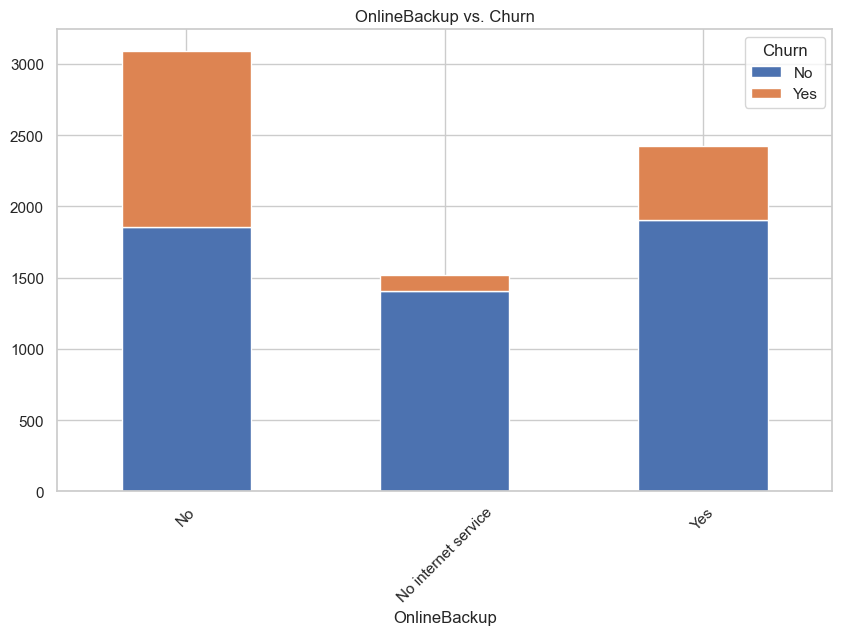

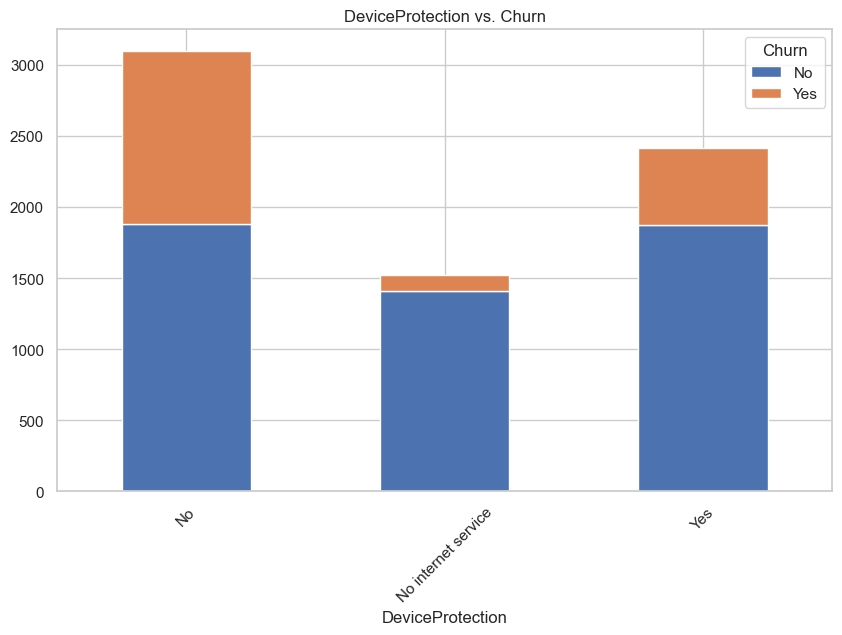

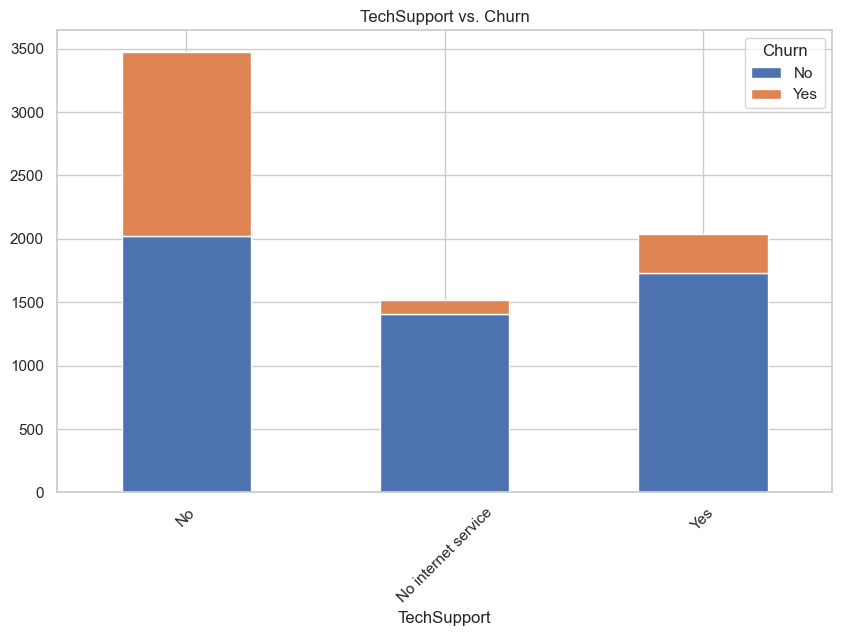

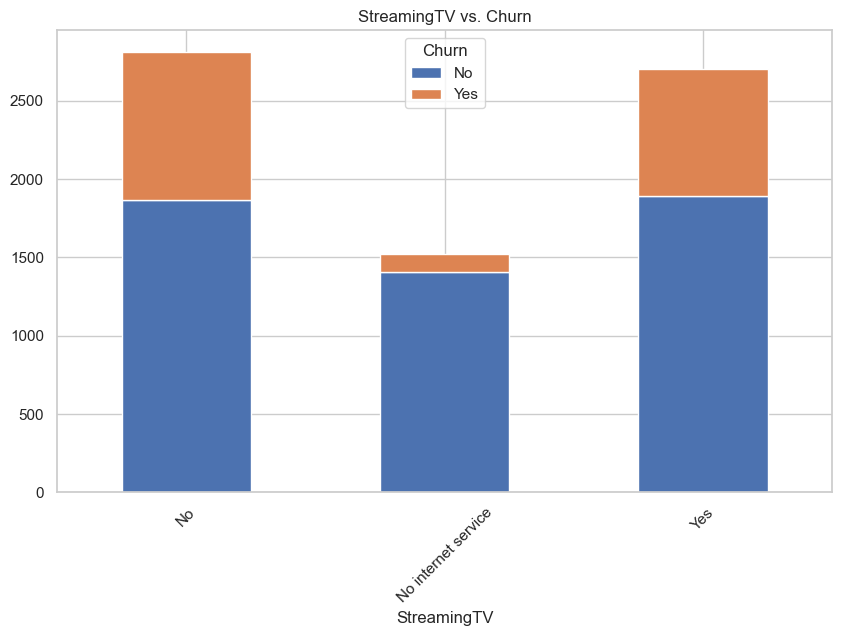

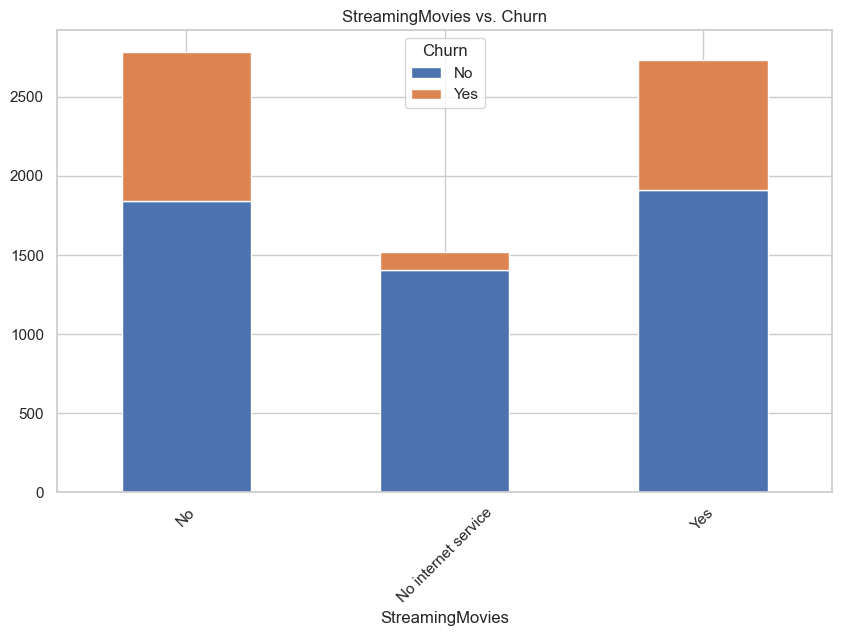

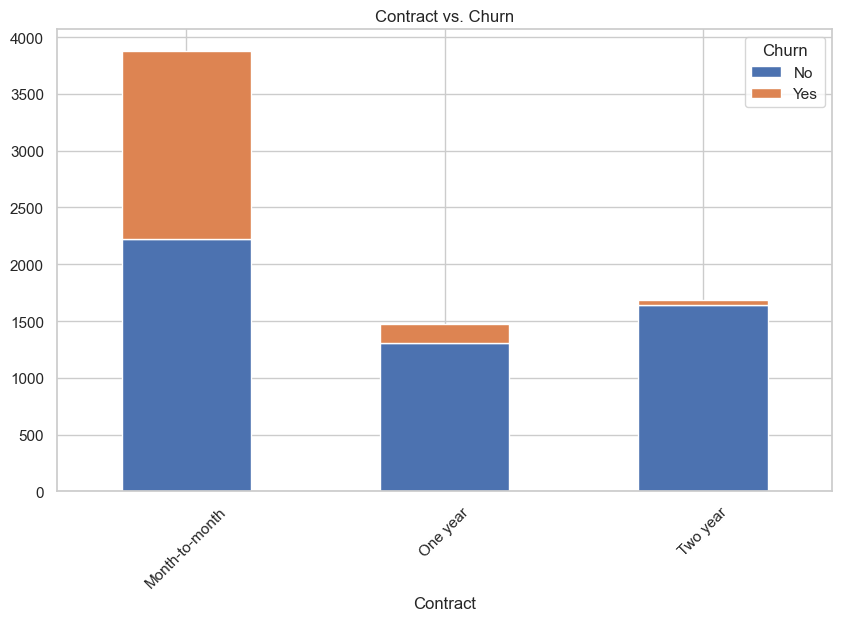

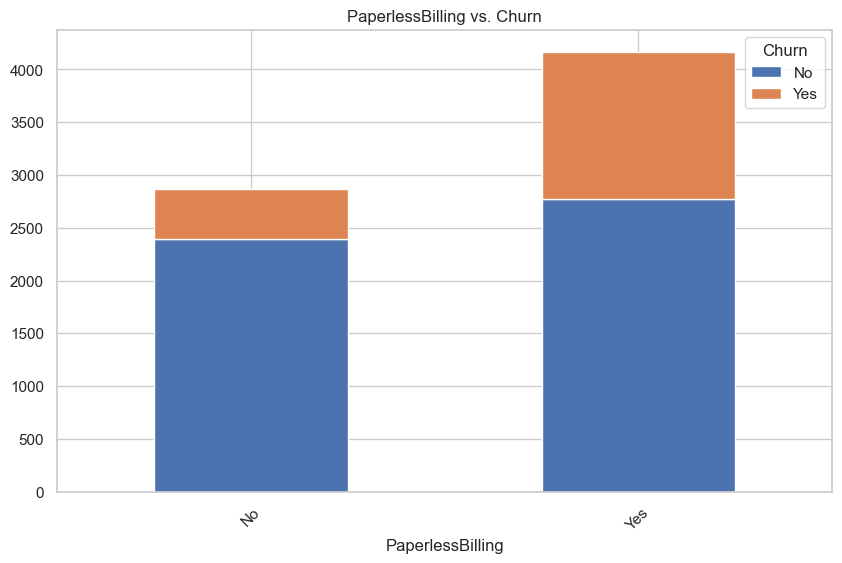

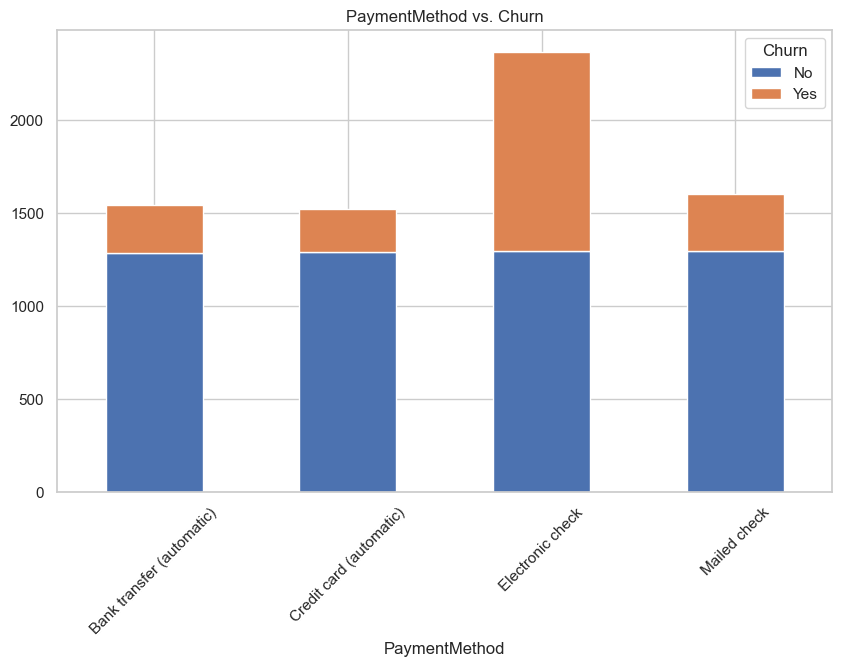

In [7]:
for col in CATEGORICAL_FEATURES:
    if col != TARGET_COLUMN:
        pd.crosstab(df[col], df[TARGET_COLUMN]).plot(kind='bar', stacked=True, figsize=(10, 6))
        plt.title(f'{col} vs. Churn')
        plt.xticks(rotation=45)
        plt.show()

## 5. Multivariate Analysis

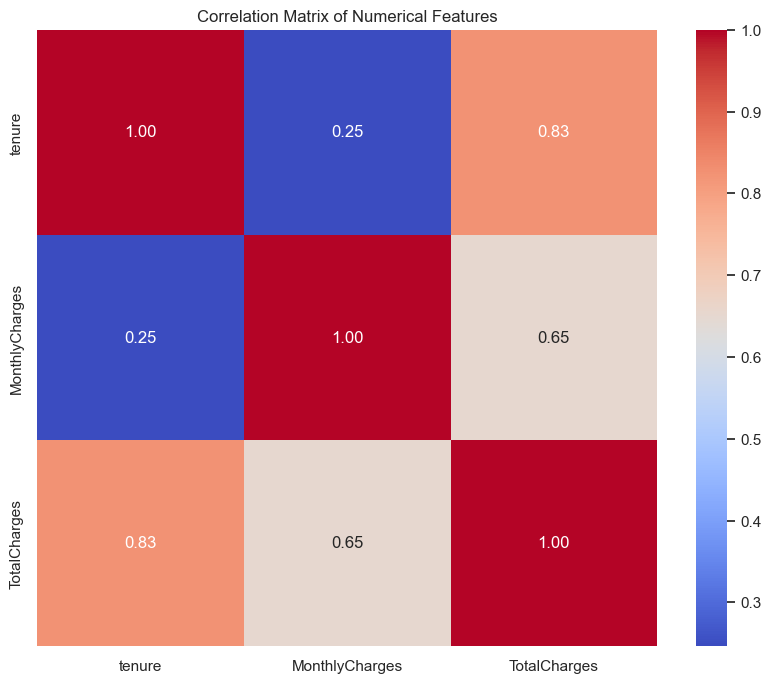

In [8]:
plt.figure(figsize=(10, 8))
correlation_matrix = df[NUMERICAL_FEATURES].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix of Numerical Features')
plt.show()

## 6. Customer Segmentation (Example)

C:\Users\IPK\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] The system cannot find the file specified
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "C:\Users\IPK\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
        "wmic CPU Get NumberOfCores /Format:csv".split(),
        capture_output=True,
        text=True,
    )
  File "C:\Users\IPK\anaconda3\Lib\subprocess.py", line 554, in run
    with Popen(*popenargs, **kwargs) as process:
         ~~~~~^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\IPK\anaconda3\Lib\subprocess.py", line 1039, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
    ~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^

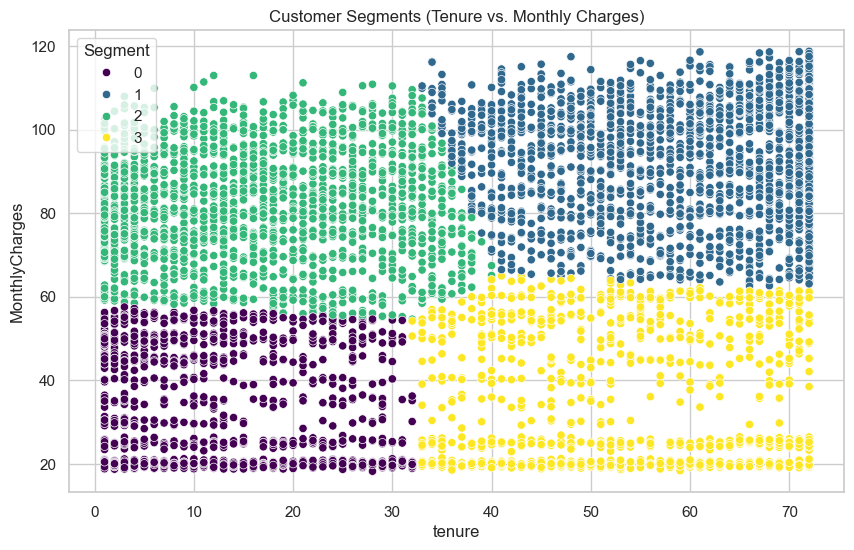

In [9]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

cluster_features = ['tenure', 'MonthlyCharges']
df_cluster = df[cluster_features].copy()

scaler = StandardScaler()
df_scaled = scaler.fit_transform(df_cluster)

kmeans = KMeans(n_clusters=4, random_state=42, n_init=10)
df['Segment'] = kmeans.fit_predict(df_scaled)

plt.figure(figsize=(10, 6))
sns.scatterplot(x='tenure', y='MonthlyCharges', hue='Segment', data=df, palette='viridis')
plt.title('Customer Segments (Tenure vs. Monthly Charges)')
plt.show()

## 7. Business Insights

In [10]:
df['Churn_numeric'] = (df[TARGET_COLUMN] == 'Yes').astype(int)
segment_analysis = df.groupby('Segment').agg({
    'tenure': 'mean',
    'MonthlyCharges': 'mean',
    'Churn_numeric': 'mean'
}).rename(columns={'Churn_numeric': 'ChurnRate'})

print('--- Segment Analysis ---')
print(segment_analysis)

print('\n--- Insights ---')
for i, row in segment_analysis.iterrows():
    print(f'- Segment {i}: Average tenure of {row.tenure:.1f} months, average monthly charge of ${row.MonthlyCharges:.2f}, and a churn rate of {row.ChurnRate:.2%}.')

--- Segment Analysis ---
            tenure  MonthlyCharges  ChurnRate
Segment                                      
0        10.536543       32.482454   0.246520
1        58.738351       93.013108   0.156682
2        14.820909       81.228841   0.492273
3        54.115152       34.028745   0.047619

--- Insights ---
- Segment 0: Average tenure of 10.5 months, average monthly charge of $32.48, and a churn rate of 24.65%.
- Segment 1: Average tenure of 58.7 months, average monthly charge of $93.01, and a churn rate of 15.67%.
- Segment 2: Average tenure of 14.8 months, average monthly charge of $81.23, and a churn rate of 49.23%.
- Segment 3: Average tenure of 54.1 months, average monthly charge of $34.03, and a churn rate of 4.76%.
